<a href="https://colab.research.google.com/github/mralamdari/CV-Yolo/blob/main/YOLO_v3_ObjectDetection_TensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import struct

# import scipy.io
# import scipy.misc
# import PIL
# import cv2
# from skimage.transform import resize

# import tensorflow as tf
# from keras import backend as K
# from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
# from keras.models import load_model, Model
# from keras.layers.merge import add, concatenate
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array

# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
# from matplotlib.patches import Rectangle

In [1]:
import os
import cv2
import PIL
import struct # used to convert native Python data types such as strings and numbers into a string of bytes and vice versa
import scipy.io
import scipy.misc
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d aruchomu/data-for-yolo-v3-kernel
!unzip \*.zip && rm *.zip

 98% 263M/267M [00:01<00:00, 250MB/s]
100% 267M/267M [00:01<00:00, 249MB/s]
Archive:  data-for-yolo-v3-kernel.zip
  inflating: coco.names              
  inflating: detections.gif          
  inflating: dog.jpg                 
  inflating: futur.ttf               
  inflating: office.jpg              
  inflating: yolov3.weights          


## Extracting YOLO v3 weights
`Read_Weights` class is used to extract the model weights from the "yolov3.weights" file into a suitbale format that can be used for keras. The class is also used to integrate the Darknet and YOLO architecures.

Yolo is an algorithm that uses convolutional neural networks for object detection. So what's great about object detection? In comparison to recognition algorithms, a detection algorithm does not only predict class labels, but detects locations of objects as well.

In [4]:
class Read_weights:

  def __init__(self, file_name):

    with open(file_name, 'rb') as weights_file:
      major, = struct.unpack('i', weights_file.read(4))
      minor, = struct.unpack('i', weights_file.read(4))
      revision, = struct.unpack('i', weights_file.read(4))

      if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
        weights_file.read(8)
      else: 
        weights_file.read(4)
      
      transpose = (major > 1000) or (minor > 1000)
      binary = weights_file.read()

    self.offset = 0
    self.all_weights = np.frombuffer(binary, dtype='float32')



    def read_bytes(self, size):
        self.offset = self.offset + size

        return self.all_weights[self.offset-size: self.offset]

 

    def load_weights(self, model):
      
      for i in range(106):
        try:
          conv_layer = model.get_layer(f'conv_{i}')
          print(f'Loading weights of convolution layer {i}')

          if i not in [81, 93, 105]

        except ValueError:
          print(f'Layer {i}; Not A Convolution Layer')


    def load_weights(self, model):

        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:

                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance

                    weights = norm_layer.set_weights([gamma, beta, mean, var])

                if len(conv_layer.get_weights()) > 1:

                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])

                else:

                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])

            except ValueError:
                print("no convolution #" + str(i))
 
    def reset(self):
        self.offset = 0

IndentationError: ignored

## Construction of the YOLO model
- `conv_block` is a function to create convolutional layers for CNN
- `make_yolov3_model` is a function to create layers of convoluational and stack together as a whole yolo model (Since YOLO v3 uses darknet for feature extraction we will be constructing the model accordingly)

For feature extraction Yolo uses Darknet-53 neural net pretrained on ImageNet. Same as ResNet, Darknet-53 has shortcut (residual) connections, which help information from earlier layers flow further. We omit the last 3 layers (Avgpool, Connected and Softmax) since we only need the features.



In [ ]:
def conv_block(inp, convs, skip=True):

    x = inp
    count = 0
    
    for conv in convs:

        if count == (len(convs) - 2) and skip:
            skip_connection = x

        count += 1
        if conv['stride'] > 1 :  x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefers left and top

        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides = conv['stride'],
                   padding = 'valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefers left and top
                   name = 'conv_' + str(conv['layer_idx']),
                   use_bias = False if conv['bnorm'] else True)(x)

        if conv['bnorm']: x = BatchNormalization(epsilon = 0.001, name = 'bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha = 0.1, name = 'leaky_' + str(conv['layer_idx']))(x)
            
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():

    input_image = Input(shape=(None, None, 3))

    # Layers 0 to 4
    x = conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layers 5 to 8
    x = conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layers 9 to 11
    x = conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layers 12 to 15
    x = conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layers 16 to 36
    for i in range(7):
        x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    
    # Layers 37 to 40
    x = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layers 41 to 61
    for i in range(7):
        x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x

    # Layers 62 to 65
    x = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layers 66 to 74
    for i in range(3):
        x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    # Layers 75 to 79
    x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layers 80 to 82
    yolo_82 = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                             {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layers 83 to 86
    x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layers 87 to 91
    x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layers 92 to 94
    yolo_94 = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                                                                                     {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layers 95 to 98
    x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layers 99 to 106
    yolo_106 = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                                {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                                {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                                {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

#Define the model

In [ ]:
# define the yolo v3 model
yolov3 = make_yolov3_model()

# load the weights
# weight_reader = Read_Weights("../input/data-for-yolo-v3-kernel/yolov3.weights")
weight_reader = Read_Weights("/content/yolov3.weights")


# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
yolov3.save('yolo_model.h5')

In [ ]:
def load_image_pixels(filename, shape):

  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size = shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = np.expand_dims(image, 0)
  return image, width, height

 ## Bounding Boxes


In [ ]:
class BoundBox:

    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.get_score

def _sigmoid(x):
    return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):

    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):

            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue

            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height

            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)

    return boxes

## `correct_yolo_boxes` is used to resize the bounding boxes to the original image shape.

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):

    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):

        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

## Non Max Supression (NMS) and Intersection over Union (IOU)
### `interval_overlap` function is used to find the overlapping regions

### `bbox_iou` function is the implementation of IOU

### `nms` function is the implementation of NMS



In [ ]:
def interval_overlap(interval_a, interval_b):

    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):

    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def nms(boxes, nms_thresh):

    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return

    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):

    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box

    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
  
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()

    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]

        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = plt.Rectangle((x1, y1), width, height, fill = False, color = 'red', linewidth = '2')

        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color = 'b')

    # show the plot
    plt.show()

## Anchors and labels


In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

## Make predictions

In [ ]:
input_w, input_h = 416, 416

def predict_boxes(image_names):
    for image_name in image_names:
      image, image_w, image_h = load_image_pixels(image_name, (input_w, input_h))

      # make prediction
      yhat = yolov3.predict(image)
      # summarize the shape of the list of arrays
      print([a.shape for a in yhat])

      boxes = list() 
      for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

      # correct the sizes of the bounding boxes for the shape of the image
      correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

      # suppress non-maximal boxes
      nms(boxes, 0.5)

      # get the details of the detected objects
      v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

      # summarize what we found
      for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

      # draw what we found
      draw_boxes(image_name, v_boxes, v_labels, v_scores)

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
truck 95.07625102996826
bicycle 98.59656095504761
dog 99.74659085273743


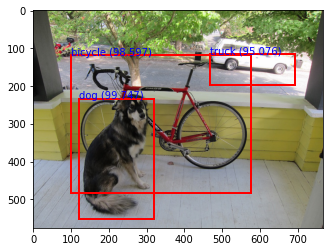

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 75.44342279434204
person 97.65632748603821
tvmonitor 92.88041591644287
person 84.24032330513
person 99.7834324836731
person 97.210693359375
chair 74.42907094955444
chair 84.44294929504395
chair 99.31058883666992


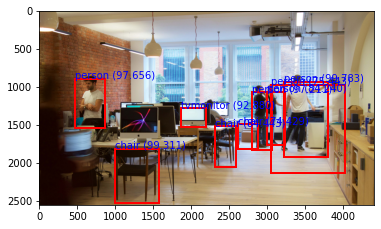

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 81.3982367515564
bicycle 97.07776308059692
dog 99.92220997810364
car 79.54714298248291
person 61.143773794174194


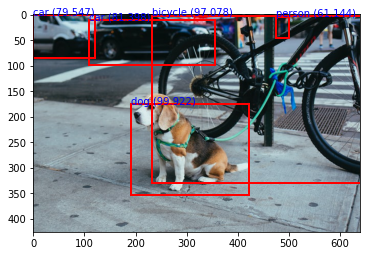

In [ ]:
# image_names = ["../input/data-for-yolo-v3-kernel/dog.jpg", "../input/data-for-yolo-v3-kernel/office.jpg"]
image_names = ["/content/dog.jpg", "/content/office.jpg", 
               '/content/anthony-fomin-xNOslF_987U-unsplash (1).jpg']

predict_boxes(image_names)